In [106]:
from __future__ import division

%matplotlib inline

import zipfile
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# national_counties = gpd.read_file('./tl_2014_us_county/tl_2014_us_county.shp')
# tx_counties = national_counties.loc[national_counties.STATEFP == '48']
# tx_counties.to_file('texas_counties.shp')

In [4]:
tx = gpd.read_file('./tx_counties/texas_counties.shp')

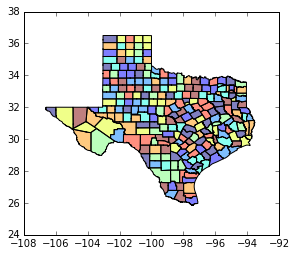

In [5]:
tx.plot()

In [6]:
county_fips_list = ['021', '055', '209', '453', '491']

austin_counties = tx.loc[tx.COUNTYFP.isin(county_fips_list)]
print len(austin_counties)

5


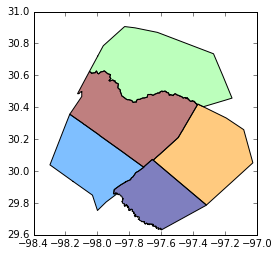

In [7]:
austin_counties_plot = austin_counties.plot()

In [8]:
pumas = gpd.read_file('./tl_2014_48_puma10/tl_2014_48_puma10.shp')

In [9]:
austin_pumas = gpd.sjoin(pumas, austin_counties)

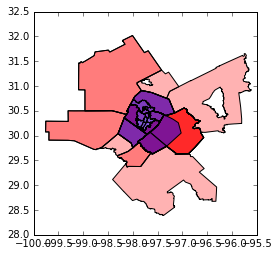

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

austin_pumas.plot(ax=ax, 
                  color='red',
                  alpha=.3)


austin_counties.plot(ax=ax,
                     color='blue')

plt.show()

In [11]:
# Looks like they nest but intersect is the wrong join

austin_pumas = gpd.sjoin(pumas, austin_counties, op='within')

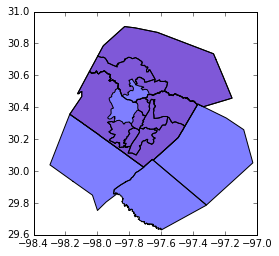

In [12]:
# BETTER!

fig, ax = plt.subplots()
ax.set_aspect('equal')

austin_pumas.plot(ax=ax, 
                  color='red',
                  alpha=.3)


austin_counties.plot(ax=ax,
                     color='blue')

plt.show()

In [13]:
len(austin_pumas)

11

In [14]:
list_austin_pumas = austin_pumas.PUMACE10.astype('int').tolist()
print list_austin_pumas

[5202, 5204, 5201, 5301, 5304, 5303, 5302, 5307, 5306, 5308, 5309]


In [15]:
with zipfile.ZipFile('csv_ptx.zip') as archive:
    
    csv = archive.open('ss14ptx.csv')
    pums = pd.read_csv(csv)

In [52]:
pums.head()

,RT,SERIALNO,SPORDER,PUMA,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,...,pwgtp71,pwgtp72,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80
0,P,3,1,3602,48,1008425,90,69,1,,...,101,30,31,25,95,79,76,87,91,25
1,P,3,2,3602,48,1008425,82,53,1,,...,81,27,24,21,98,67,69,93,101,21
2,P,3,3,3602,48,1008425,128,11,1,,...,113,42,47,35,128,108,100,116,127,27
3,P,5,1,6603,48,1008425,112,68,1,,...,114,99,140,31,110,111,109,178,100,205
4,P,5,2,6603,48,1008425,97,64,1,,...,103,95,100,25,92,90,91,142,101,211


In [53]:
# Recode race/ethnicity

pums.loc[pums.HISP != 1, 'race_eth'] = 'Hispanic/Latino'
pums.loc[pums.RAC1P == 1, 'race_eth'] = 'White Alone'
pums.loc[pums.RAC1P == 2, 'race_eth'] = 'Black Alone'
pums.loc[pums.RAC1P == 6, 'race_eth'] = 'Asian Alone'
pums.loc[pums.race_eth.isnull(), 'race_eth'] = 'Multiracial/Other'

In [87]:
# Dummy variables

pums['black'] = 0
pums.loc[pums.race_eth == 'Black Alone', 'black'] = 1

In [88]:
austin_pums = pums.loc[pums.PUMA.isin(list_austin_pumas)]
print len(austin_pums), len(pums)

13286 254883


In [89]:
austin_workers = austin_pums.loc[austin_pums.COW.isin(range(1,9))]

In [90]:
# Filter for industries

industries = ['5121', '515']

# 5121 MOTION PICTURE AND VIDEO INDUSTRIES
# 515 BROADCASTING, EXCEPT INTERNET

df = pums.loc[pums.NAICSP.isin(industries)]
len(df)

654

In [91]:
df.NAICSP.value_counts()

515     364
5121    290
Name: NAICSP, dtype: int64

In [92]:
# Check worker status

df.COW.value_counts(sort=False)

# All looks good

1.0    568
2.0     30
3.0      2
4.0      4
5.0      4
6.0     28
7.0     15
8.0      3
Name: COW, dtype: int64

In [93]:
# Age

df.AGEP.describe()

count    654.000000
mean      38.068807
std       15.729232
min       16.000000
25%       24.000000
50%       35.000000
75%       50.000000
max       92.000000
Name: AGEP, dtype: float64

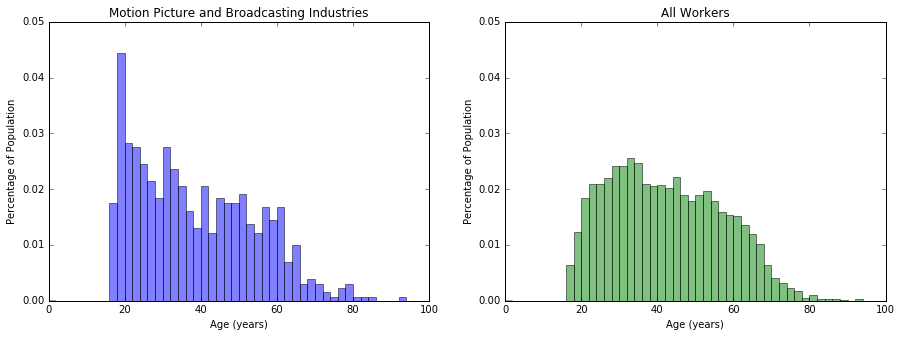

In [94]:
fig = plt.figure(figsize=[15,5])

colors = ['blue', 'green']
titles = ['Motion Picture and Broadcasting Industries', 'All Workers']

agebins = [i for i in range(0,100,2)]

for i, var in enumerate([df.AGEP, austin_workers.AGEP]):
    ax = fig.add_subplot(1, 2, i+1)
    ax.hist(var,
            bins=agebins,
            alpha=0.5,
            normed=True,
            color=colors[i])
    ax.set_ylim([0, 0.05])
    ax.set_title(titles[i])
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('Percentage of Population')

plt.show()

In [108]:
# Comparison Table

def comparison_table(df, austin_workers, variable):
        
    counts_industry = df[variable].value_counts()
    counts = pd.DataFrame(counts_industry)

    counts_austin = pd.DataFrame(austin_workers[variable].value_counts())
    counts = counts.merge(counts_austin, left_index=True, right_index=True)
    counts.columns = ['industries', 'austin']
    
    counts['industries_pct'] = counts.apply(lambda row: row.industries / counts.industries.sum(), axis=1)
    counts['austin_pct'] = counts.apply(lambda row: row.austin / counts.austin.sum(), axis=1)
    
    return counts

In [109]:
comparison_table(df, austin_workers, 'race_eth')

,industries,austin,industries_pct,austin_pct
White Alone,524,6859,0.801223,0.816742
Black Alone,63,558,0.096330,0.066444
Asian Alone,21,429,0.032110,0.051084
Hispanic/Latino,36,397,0.055046,0.047273
Multiracial/Other,10,155,0.015291,0.018457


In [112]:
black_comp = comparison_table(df, austin_workers, 'black')
black_comp

,industries,austin,industries_pct,austin_pct
0,591,7840,0.90367,0.933556
1,63,558,0.09633,0.066444


In [118]:
black_np_array = black_comp.iloc[:,:-2].as_matrix()
stats.chi2_contingency(black_np_array)

(8.0199762729999975,
 0.004626417644172421,
 1,
 array([[  609.13323023,  7821.86676977],
        [   44.86676977,   576.13323023]]))

In [119]:
# Foreign born

comparison_table(df, austin_workers, 'NATIVITY')

,industries,austin,industries_pct,austin_pct
1,589,7132,0.900612,0.84925
2,65,1266,0.099388,0.15075


In [159]:
# Income

adj = 1.008425

df['income'] = df.PINCP.astype(int) * adj
austin_workers['income'] = austin_workers.PINCP.astype(int) * adj

/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [150]:
df.ADJINC.value_counts()

1008425    654
Name: ADJINC, dtype: int64

In [151]:
i_wages.describe()

count       618.000000
mean      36371.758677
std       37076.706840
min          60.505500
25%        8974.982500
50%       29042.640000
75%       48404.400000
max      192609.175000
Name: PINCP, dtype: float64

In [152]:
a_wages.describe()

count      7778.000000
mean      44108.101229
std       37034.504547
min           1.008425
25%       16134.800000
50%       35294.875000
75%       60505.500000
max      199668.150000
Name: PINCP, dtype: float64

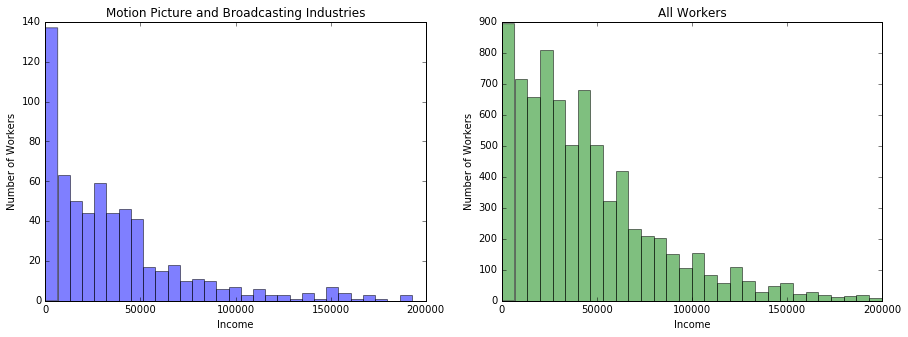

In [153]:
fig = plt.figure(figsize=[15,5])

colors = ['blue', 'green']
titles = ['Motion Picture and Broadcasting Industries', 'All Workers']

# agebins = [i for i in range(0,100,2)]

for i, var in enumerate([i_wages, a_wages]):
    ax = fig.add_subplot(1, 2, i+1)
    ax.hist(var,
            bins=30,
            alpha=0.5,
#             normed=True,
            color=colors[i])
#     ax.set_ylim([0, 0.01])
    ax.set_title(titles[i])
    ax.set_xlabel('Income')
    ax.set_ylabel('Number of Workers')

plt.show()

In [185]:
income_df = pd.DataFrame()

cols = ['industries', 'austin']

for race in pums.race_eth.unique():
    
    a = df[df.race_eth == race].income.clip(upper=250000)
    b = austin_workers[austin_workers.race_eth == race].income.clip(upper=250000)
    ttest = stats.ttest_ind(a, b)
    pval = ttest[1]
    sig = pval < 0.05
    
    income_df.loc[race, 'industries'] = a.mean()
    income_df.loc[race, 'austin'] = b.mean()
    income_df.loc[race, 'p-value'] = pval
    income_df.loc[race, 'sig95'] = sig

In [186]:
income_df

,industries,austin,p-value,sig95
White Alone,37984.143151,50982.919882,2.910602e-08,True
Hispanic/Latino,27439.020156,30982.914084,5.251600e-01,False
Black Alone,30014.889754,32713.431771,5.205659e-01,False
Multiracial/Other,40805.917625,30602.250587,3.414303e-01,False
Asian Alone,43698.608748,47799.308397,7.204091e-01,False
